# Using InceptionV3 as a base model for transfer learning

Now that I've trained a simple model using InceptionV3 as a base, using only one Dense layer before output, I'd like to iterate on it to see how I can improve it. I'll be doing the same for VGG-16 and comparing the two in order to make a final decision for my best model.

In [11]:
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Flatten, Dropout
from keras.applications.inception_v3 import InceptionV3
from pickle import dump

from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [12]:
# Image folder for training
train_dir = 'input_images/full_combined'
val_dir = 'input_images/validation'

# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [13]:
# Make generators -- NOW USING SEPARATE VALIDATION SET/FOLDER (see split-folders.ipynb for details)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True,
                                   rotation_range=20, 
                                   brightness_range=[0.5, 1.5], 
                                   zoom_range=.2)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, class_mode='binary', shuffle=False)

Found 1619 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Instantiate base model

I'll use the InceptionV3 model without its original Dense layers for feature extraction. I'll then add my own Dense layers and sigmoid activation output.

In [14]:
# Get base model
incep_base_model = InceptionV3(weights='imagenet', 
                               include_top=False,
                               input_shape=(256, 256, 3))

# Freeze layers
for layer in incep_base_model.layers:
    layer.trainable = False
    
# Check architecture
incep_base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 127, 127, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 127, 127, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

## Iterations

Before, I simply added one Dense(512) layer on top of the base architecture.

I'll use `train_gen` and `val_gen` as defined above.

### Top with 2 Dense(512) layers 

In [15]:
# Instantiate model
incep_1 = models.Sequential()

# Add base model
incep_1.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_1.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation
incep_1.add(Dense(512, activation='relu'))
incep_1.add(Dense(512, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
incep_1.add(Dense(1, activation='sigmoid'))

# Compile
incep_1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [16]:
# Train the model
incep_1_history = incep_1.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 235s 5s/step - loss: 3.9878 - acc: 0.7381 - recall: 0.7561 - precision: 0.7526 - val_loss: 0.3927 - val_acc: 0.8800 - val_recall: 0.7600 - val_precision: 1.0000
Epoch 2/20
51/51 [==============================] - 221s 4s/step - loss: 0.5851 - acc: 0.8153 - recall: 0.8258 - precision: 0.8267 - val_loss: 0.3028 - val_acc: 0.8900 - val_recall: 0.7800 - val_precision: 1.0000
Epoch 3/20
51/51 [==============================] - 218s 4s/step - loss: 0.3681 - acc: 0.8493 - recall: 0.8502 - precision: 0.8642 - val_loss: 0.3257 - val_acc: 0.8900 - val_recall: 0.7800 - val_precision: 1.0000
Epoch 4/20
51/51 [==============================] - 216s 4s/step - loss: 0.3332 - acc: 0.8734 - recall: 0.8699 - precision: 0.8895 - val_loss: 0.2410 - val_acc: 0.9000 - val_recall: 0.9200 - val_precision: 0.8846
Epoch 5/20
51/51 [==============================] - 216s 4s/step - loss: 0.4002 - acc: 0.8518 - recall: 0.8490 - precision: 0.8692 - val_loss: 0.261

In [17]:
incep_1.save('models/incep_1.h5')

Training eval:
51/51 [==============================] - 216s 4s/step - loss: 0.2104 - acc: 0.9092 - recall: 0.9663 - precision: 0.8758

Validation eval:
4/4 [==============================] - 7s 2s/step - loss: 0.1752 - acc: 0.9100 - recall: 0.9400 - precision: 0.8868


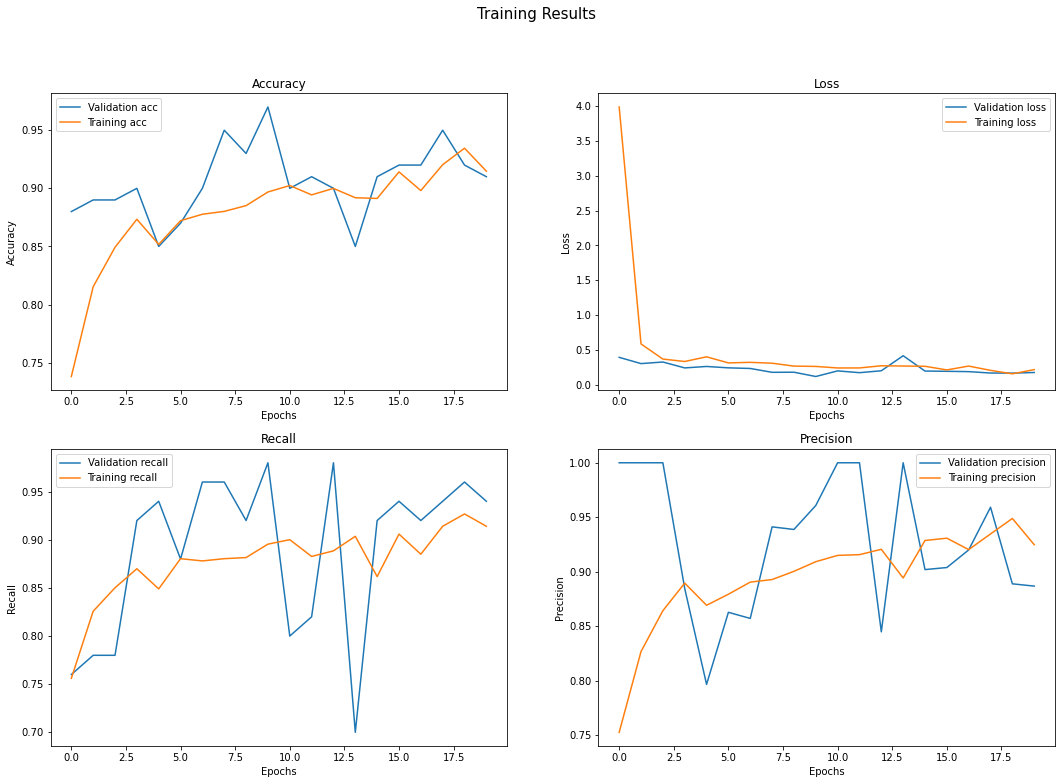

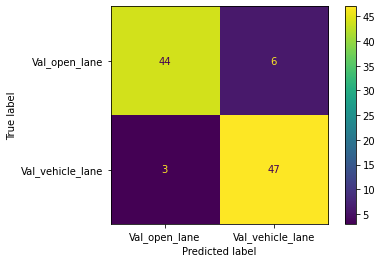

In [18]:
visualize_results(incep_1_history, incep_1, train_gen, val_gen)

In [19]:
dump(incep_1_history.history, open('models/incep_1_history.pkl', 'wb'))

### 2 Dense layers and aggressive (0.5) Dropout to avoid overfitting

In [ ]:
# Instantiate model
incep_2 = models.Sequential()

# Add base model
incep_2.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_2.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation,
# plus Dropout layers
incep_2.add(Dense(512, activation='relu'))
incep_2.add(Dropout(0.5))
incep_2.add(Dense(512, activation='relu'))
incep_2.add(Dropout(0.5))

# Add a final sigmoid layer with 1 node for classification output
incep_2.add(Dense(1, activation='sigmoid'))

# Compile
incep_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [ ]:
# Train the model
incep_2_history = incep_2.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen)

In [ ]:
incep_2.save('models/incep_2.h5')

In [ ]:
visualize_results(incep_2_history, incep_2, train_gen, val_gen)

In [ ]:
dump(incep_2_history.history, open('models/incep_2_history.pkl', 'wb'))

### More Dense layers with decreasing number of nodes

In [ ]:
# Instantiate model
incep_3 = models.Sequential()

# Add base model
incep_3.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_3.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation,
# plus Dropout layers
incep_3.add(Dense(512, activation='relu'))
incep_3.add(Dense(128, activation='relu'))
incep_3.add(Dense(32, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
incep_3.add(Dense(1, activation='sigmoid'))

# Compile
incep_3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [ ]:
# Train the model
incep_3_history = incep_3.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen)

In [ ]:
incep_3.save('models/incep_3.h5')

In [ ]:
visualize_results(incep_3_history, incep_3, train_gen, val_gen)

In [ ]:
dump(incep_3_history.history, open('models/incep_3_history.pkl', 'wb'))